## Statistical analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import functions as fun

from scipy import stats
import scipy.stats as st
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

%matplotlib inline

In [2]:
df_demo = pd.read_csv("../data/df_demo.csv")
df_exp = pd.read_csv("../data/df_experiment_tot.csv")
df_final = pd.read_csv("../data/df_final.csv")

In [3]:
df_final["Variation"] = df_final["Variation"].map(fun.replace_nan)
df_final_included = df_final[ df_final["Variation"].isin(["Test", "Control"])]

In [4]:
df_exp_final = pd.merge(df_final_included, df_exp, on = "client_id", how = "inner") 

In [5]:
df_test = df_exp_final[df_exp_final["Variation"] == "Test"]
df_control = df_exp_final[df_exp_final["Variation"] == "Control"]

## Completion rate

Null hypothesis --> there is no difference in the completion rate between the old version of the website and the new web design (**rejected**).

**Results** = the completion rate of clients who were exposed to the new web design is significantly higher than the ones exposed to the old version (p-value < 0.0001). In this case, the data from both groups did not follow a normal distribution, so the statistical test performed was a Mann-Whitney U test (the test ranks all values from low to high and compares the mean of the ranks).

In [72]:
average_ctrl,_ = fun.completion_rate(df_control)
average_test,_ = fun.completion_rate(df_test)

print(f"""The average completion rate for the control group is: {average_ctrl}%
The average completion rate for the test group is: {average_test}%""")

The average completion rate for the control group is: 17.66%
The average completion rate for the test group is: 20.6%


In [73]:
_,completion_rate_ctrl = fun.completion_rate(df_control)
_,completion_rate_test = fun.completion_rate(df_test)

### Check for normality 

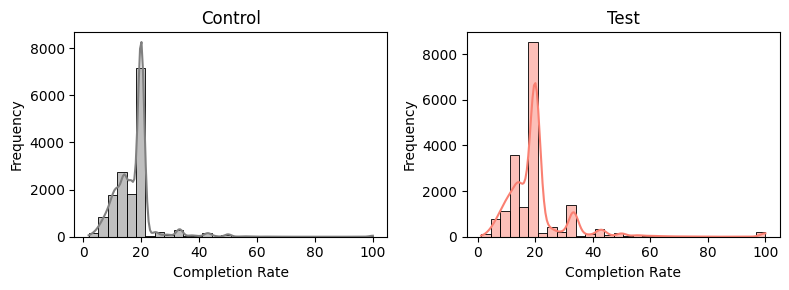

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

sns.histplot(completion_rate_ctrl, bins=30, kde=True, color="grey", alpha=0.5, ax = ax1)
ax1.set_title("Control")
ax1.set_xlabel("Completion Rate")
ax1.set_ylabel("Frequency")


sns.histplot(completion_rate_test, bins=30, kde=True, color="salmon", alpha=0.5, ax = ax2)
ax2.set_title("Test")
ax2.set_xlabel("Completion Rate")
ax2.set_ylabel("Frequency")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


- Kolmogorov-Smirnov Test to check if data follow a **normal distribution**

In [41]:
# CONTROL

standardized_rate_ctrl = (completion_rate_ctrl - completion_rate_ctrl.mean()) / completion_rate_ctrl.std(ddof=1)
ks_test_statistic, ks_p_value = stats.kstest(standardized_rate_ctrl, 'norm')

ks_test_statistic, ks_p_value

(0.3173879705047148, 0.0)

In [43]:
# TEST

standardized_rate_test = (completion_rate_test - completion_rate_test.mean()) / completion_rate_test.std(ddof=1)
ks_test_statistic, ks_p_value = stats.kstest(standardized_rate_test, 'norm')

ks_test_statistic, ks_p_value

(0.34276045404099575, 0.0)

(0.24318221004907714, 0.0)

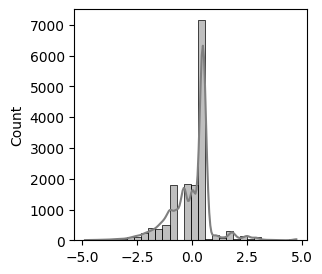

In [47]:
log_transformed_rate_ctrl = np.log1p(completion_rate_ctrl) 
standardized_log_rate_ctrl = (log_transformed_rate_ctrl - log_transformed_rate_ctrl.mean()) / log_transformed_rate_ctrl.std(ddof=1)


plt.figure(figsize=(3,3))
sns.histplot(standardized_log_rate_ctrl, kde=True, bins=30, color="grey")

ks_test_statistic, ks_p_value = stats.kstest(standardized_log_rate_ctrl, 'norm')

ks_test_statistic, ks_p_value

<Axes: ylabel='Count'>

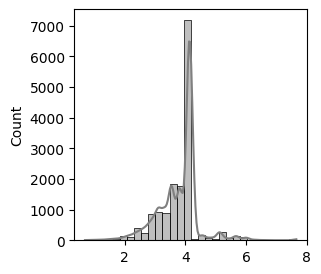

In [48]:
rate_ctrl_boxcox, _ = st.boxcox(completion_rate_ctrl)
plt.figure(figsize=(3,3))
sns.histplot(rate_ctrl_boxcox, kde=True, bins=30, color="grey")

**Data from completion rate do not follow a normal distribution (even after transforming them), therefore I will compare them with Mann-Whitney U test, non-parametric test equal to the t-test for two samples**

In [52]:
statistic, p_value = mannwhitneyu(completion_rate_ctrl.values, completion_rate_test.values)
print(f"""statistic: {statistic: .3f}, 
p_value: {p_value}""")

statistic:  123217741.500, 
p_value: 1.9205656300064737e-131


In [74]:
rate_df = pd.concat([completion_rate_ctrl.rename("Control"), completion_rate_test.rename("Test")], axis=1)
rate_df_melted = rate_df.melt(var_name="Group", value_name="Completion Rate")

rate_df_melted.to_csv("../data/for_tableau/Compl_rate_ctrl_test.csv", index=False)
rate_df_melted

,Group,Completion Rate
0,Control,20.0
1,Control,14.3
2,Control,20.0
3,Control,14.3
4,Control,20.0
...,...,...
68237,Test,20.0
68238,Test,20.0
68239,Test,20.0
68240,Test,20.0


(0.0, 40.0)

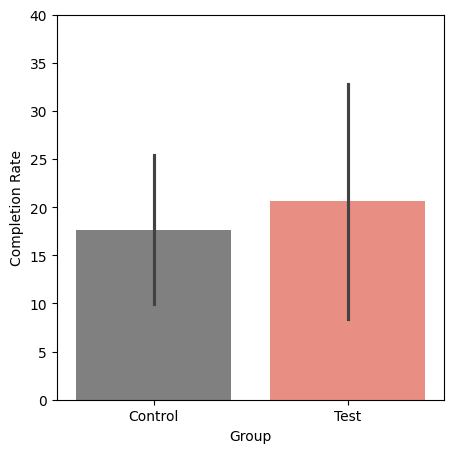

In [56]:
plt.figure(figsize=(5,5))
sns.barplot(data = rate_df_melted, x="Group", y="Completion Rate", hue = "Group", errorbar="sd", 
            palette = {"Control":"grey", "Test":"salmon"})
plt.ylim(0,40)

## Average duration users spend on each step

Null hypothesis: there is no difference in the average time clients spend on each step of the process between the old version of the website and the new web design.

1) Is the mean total process time for all the clients significanlty different between the control and test group?
2) Is the mean spent in each step the same among all steps? Is there a difference between control and test group?

**Results**

In [11]:
average_ctrl, tot_ctrl, df_time_ctrl = fun.time_steps(df_control)

C:\Users\laura\Documents\IronHack\Module_2\Project_2\notebooks\functions.py:227: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date_time"] = pd.to_datetime(df["date_time"])


The average activity duration of clients for each step is:
    Between Start and Step_1:  25.62 seconds
    Between Step_1 and Step_2:  31.77 seconds
    Between Step_2 and Step_3:  74.61 seconds
    Between Step_3 and Confirm:  90.29 seconds
    
    The total average duration to complete the process is:  55.57 seconds


In [7]:
df_time_ctrl.head()

,Start-Step1,Step1-Step2,Step2-Step3,Step3-Confirm
client_id,,,,
1195,33.0,98.0,31.0,83.0
1197,4.0,68.0,6.0,17.0
3743,13.0,39.0,141.0,99.0
6977,30.0,5.0,64.0,128.0
6985,35.0,46.0,51.0,199.0


In [9]:
average_test, tot_test, df_time_test = fun.time_steps(df_test)

C:\Users\laura\Documents\IronHack\Module_2\Project_2\notebooks\functions.py:227: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date_time"] = pd.to_datetime(df["date_time"])


The average activity duration of clients for each step is:
    Between Start and Step_1:  19.84 seconds
    Between Step_1 and Step_2:  27.50 seconds
    Between Step_2 and Step_3:  72.67 seconds
    Between Step_3 and Confirm:  78.09 seconds
    
    The total average duration to complete the process is:  49.53 seconds


In [75]:
df_time_ctrl["total_time"] = df_time_ctrl[["Start-Step1", "Step1-Step2", "Step2-Step3", "Step3-Confirm"]].mean(axis=1)
df_time_test["total_time"] = df_time_test[["Start-Step1", "Step1-Step2", "Step2-Step3", "Step3-Confirm"]].mean(axis=1)

In [77]:
time_step_df = pd.concat([df_time_ctrl, df_time_test], keys = ["Control", "Test"])
time_step_df.reset_index(inplace=True)
time_step_df

,level_0,client_id,Start-Step1,Step1-Step2,Step2-Step3,Step3-Confirm,total_time,time_ctrl_sqrt
0,Control,1195,33.0,98.0,31.0,83.0,61.25,7.826238
1,Control,1197,4.0,68.0,6.0,17.0,23.75,4.873397
2,Control,3743,13.0,39.0,141.0,99.0,73.00,8.544004
3,Control,6977,30.0,5.0,64.0,128.0,56.75,7.533260
4,Control,6985,35.0,46.0,51.0,199.0,82.75,9.096703
...,...,...,...,...,...,...,...,...
20788,Test,9998773,11.0,23.0,125.0,136.0,73.75,NaN
20789,Test,9998851,7.0,26.0,101.0,31.0,41.25,NaN
20790,Test,9998964,55.0,16.0,107.0,74.0,63.00,NaN
20791,Test,9999009,8.0,26.0,19.0,118.0,42.75,NaN


In [78]:
melted_time_df = time_step_df.melt(id_vars=["client_id", "level_0"], value_vars=["Start-Step1", "Step1-Step2", "Step2-Step3", "Step3-Confirm", "total_time"], 
                                   var_name="Step", value_name="Time")

melted_time_df.to_csv("../data/for_tableau/Time_steps_ctrl_test.csv", index=False)
melted_time_df

,client_id,level_0,Step,Time
0,1195,Control,Start-Step1,33.00
1,1197,Control,Start-Step1,4.00
2,3743,Control,Start-Step1,13.00
3,6977,Control,Start-Step1,30.00
4,6985,Control,Start-Step1,35.00
...,...,...,...,...
103960,9998773,Test,total_time,73.75
103961,9998851,Test,total_time,41.25
103962,9998964,Test,total_time,63.00
103963,9999009,Test,total_time,42.75


### 1. Is the mean total process time for all the clients significanlty different between the control and test group?

In [22]:
df_time_ctrl["total_time"] = df_time_ctrl[["Start-Step1", "Step1-Step2", "Step2-Step3", "Step3-Confirm"]].mean(axis=1)
df_time_test["total_time"] = df_time_test[["Start-Step1", "Step1-Step2", "Step2-Step3", "Step3-Confirm"]].mean(axis=1)

### Check for normality 

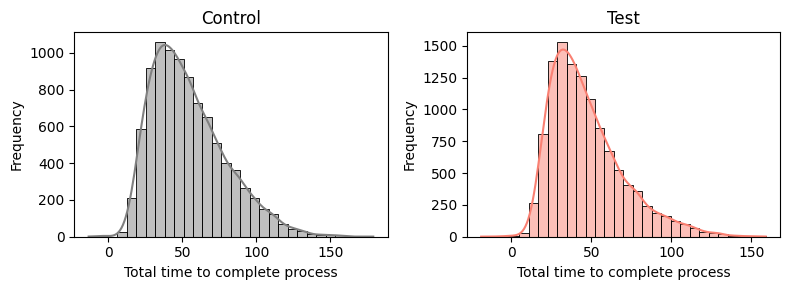

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

sns.histplot(df_time_ctrl["total_time"], bins=30, kde=True, color="grey", alpha=0.5, ax = ax1)
ax1.set_title("Control")
ax1.set_xlabel("Total time to complete process")
ax1.set_ylabel("Frequency")


sns.histplot(df_time_test["total_time"], bins=30, kde=True, color="salmon", alpha=0.5, ax = ax2)
ax2.set_title("Test")
ax2.set_xlabel("Total time to complete process")
ax2.set_ylabel("Frequency")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [24]:
# CONTROL

standardized_time_ctrl = (df_time_ctrl["total_time"] - df_time_ctrl["total_time"].mean()) / df_time_ctrl["total_time"].std(ddof=1)
ks_test_statistic, ks_p_value = stats.kstest(standardized_time_ctrl, 'norm')

ks_test_statistic, ks_p_value

(0.07690499224870329, 4.76298181612323e-48)

In [25]:
# TEST

standardized_time_test = (df_time_test["total_time"] - df_time_test["total_time"].mean()) / df_time_test["total_time"].std(ddof=1)
ks_test_statistic, ks_p_value = stats.kstest(standardized_time_test, 'norm')

ks_test_statistic, ks_p_value

(0.09193714410085324, 2.1951998413614992e-85)

<Axes: xlabel='total_time', ylabel='Count'>

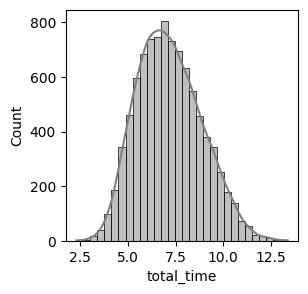

In [43]:
time_ctrl_sqrt = np.sqrt(df_time_ctrl["total_time"])
plt.figure(figsize=(3,3))
sns.histplot(time_ctrl_sqrt, kde=True, bins=30, color="grey")

0.03780587493565518 6.429293398492037e-12


<Axes: xlabel='total_time', ylabel='Count'>

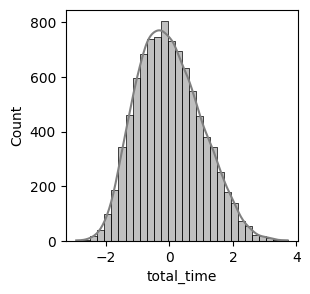

In [46]:
standardized_time_ctrl_sqrt = (time_ctrl_sqrt - time_ctrl_sqrt.mean()) / time_ctrl_sqrt.std(ddof=1)
ks_test_statistic, ks_p_value = stats.kstest(standardized_time_ctrl_sqrt, 'norm')

print(ks_test_statistic, ks_p_value)
plt.figure(figsize=(3,3))
sns.histplot(standardized_time_ctrl_sqrt, kde=True, bins=30, color="grey")

**Data from total time spent during the process do not follow a normal distribution (even after transforming them), therefore I will compare them with Mann-Whitney U test, non-parametric test equal to the t-test for two samples**

In [53]:
statistic, p_value = mannwhitneyu(df_time_ctrl["total_time"], df_time_test["total_time"])
print(f"""statistic: {statistic: .3f}, 
p_value: {p_value}""")

statistic:  62815214.500, 
p_value: 1.2799182892016153e-106


([0, 1, 2, 3, 4],
 [Text(0, 0, 'Start-Step1'),
  Text(1, 0, 'Step1-Step2'),
  Text(2, 0, 'Step2-Step3'),
  Text(3, 0, 'Step3-Confirm'),
  Text(4, 0, 'total_time')])

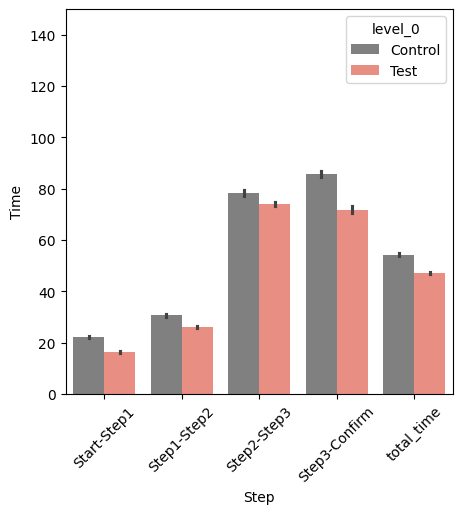

In [84]:
plt.figure(figsize=(5,5))
sns.barplot(data = melted_time_df, x="Step", y="Time", hue = "level_0", errorbar="ci", 
            palette = {"Control":"grey", "Test":"salmon"})
plt.ylim(0,150)
plt.xticks(rotation=45)

### 2. Is the mean spent in each step the same among all steps? Is there a difference between control and test group?

**Two ways anova**